In [ ]:
import pandas as pd
import geopandas as gpd

def prepare_heatmap_input_from_gdf(
    gdf: gpd.GeoDataFrame,
    year: int,
    scenario: str,
    nil_col: str = "NIL",
    category_col: str = "category",
) -> pd.DataFrame:
    """
    Prepare a plain DataFrame in the format expected by
    plot_nil_category_heatmap_posneg_scaled, starting from a GeoDataFrame
    of events.

    Parameters
    ----------
    gdf : GeoDataFrame
        Input events, one row per event occurrence. Must have NIL + category columns.
    year : int
        Year to assign to all rows (e.g. 2024).
    scenario : str
        Scenario label to assign to all rows (e.g. "real" or "reallocated").
    nil_col : str, default "NIL"
        Name of the column in `gdf` containing NIL names.
    category_col : str, default "category"
        Name of the column in `gdf` containing event categories.

    Returns
    -------
    DataFrame
        Columns: ["year", "scenario", "NIL", "category"].
        Geometry is dropped (not needed for the heatmap).
    """
    # Basic checks
    if nil_col not in gdf.columns:
        raise KeyError(f"'{nil_col}' column not found in gdf")
    if category_col not in gdf.columns:
        raise KeyError(f"'{category_col}' column not found in gdf")

    df = gdf.copy()

    # Standardise column names to what the plotting function expects
    df = df.rename(columns={
        nil_col: "NIL",
        category_col: "category",
    })

    # Add year and scenario columns (same value for all rows)
    df["year"] = int(year)
    df["scenario"] = str(scenario)

    # Keep only the columns needed by the heatmap
    df_out = df[["year", "scenario", "NIL", "category"]].copy()
    return df_out


In [ ]:
prep_real = prepare_heatmap_input_from_gdf(real_merged,year=2024,scenario='real')

In [ ]:
prep_realloc = prepare_heatmap_input_from_gdf(realloc_merged,year=2024,scenario='reallocated')

In [ ]:
df_all = pd.concat([prep_real, prep_realloc], ignore_index=True)

In [ ]:
len(prep_real[prep_real['NIL']== 'VILLAPIZZONE - CAGNOLA - BOLDINASCO'])

17

In [ ]:
prep_realloc['NIL'].unique()

array(['BANDE NERE', 'PORTA MAGENTA', 'PAGANO', 'DE ANGELI - MONTE ROSA',
       'BUENOS AIRES - PORTA VENEZIA - PORTA MONFORTE', 'SAN SIRO',
       'XXII MARZO', 'MAGENTA - S. VITTORE', 'DUOMO',
       'LORETO - CASORETTO - NOLO', 'BRERA', "CITTA' STUDI", 'GUASTALLA',
       'PORTA VIGENTINA - PORTA LODOVICA', 'ISOLA', 'PORTA GENOVA',
       'DERGANO',
       "NIGUARDA - CA' GRANDA - PRATO CENTENARO - Q.RE FULVIO TESTI",
       'MACIACHINI - MAGGIOLINA', 'SARPI', 'PORTA TICINESE - CONCHETTA',
       'GHISOLFA', 'GRECO - SEGNANO', 'PTA ROMANA',
       'PORTA TICINESE - CONCA DEL NAVIGLIO', 'MORIVIONE',
       'STAZIONE CENTRALE - PONTE SEVESO',
       'VILLAPIZZONE - CAGNOLA - BOLDINASCO', 'MONCUCCO - SAN CRISTOFORO',
       'FORZE ARMATE', 'PORTELLO', 'PADOVA - TURRO - CRESCENZAGO',
       'SCALO ROMANA', 'GIAMBELLINO', 'UMBRIA - MOLISE - CALVAIRATE',
       'STADIO - IPPODROMI',
       'STADERA - CHIESA ROSSA - Q.RE TORRETTA - CONCA FALLATA',
       'CORSICA', 'LORENTEGGIO', 'LODI - 

In [ ]:
prep_realloc

,year,scenario,NIL,category
0,2024,reallocated,BANDE NERE,community_lifestyle
1,2024,reallocated,PORTA MAGENTA,community_lifestyle
2,2024,reallocated,PAGANO,sport_fitness
3,2024,reallocated,DE ANGELI - MONTE ROSA,art_exhibitions
4,2024,reallocated,BUENOS AIRES - PORTA VENEZIA - PORTA MONFORTE,art_exhibitions
...,...,...,...,...
1323,2024,reallocated,PARCO BOSCO IN CITTA',music_concerts
1324,2024,reallocated,BRERA,art_exhibitions
1325,2024,reallocated,CITTA' STUDI,art_exhibitions
1326,2024,reallocated,Q.RE GALLARATESE - Q.RE SAN LEONARDO - LAMPUGNANO,art_exhibitions


In [ ]:
prep_real[prep_real['NIL']== 'VILLAPIZZONE']

,year,scenario,NIL,category


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

def plot_nil_category_heatmap_posneg_scaled(
    df: pd.DataFrame,
    year: int,
    categories: list[str],
    scenario_order=("real", "reallocated"),
    top_k: int | None = None,
    cmap_name: str = "RdBu_r",
    figsize=(12, 8),
    title: str | None = None,
):
    """
    Heatmap of raw change (reallocated − real) per NIL×category,
    with per-category scaling:
        positives → [0, +1], negatives → [0, −1].

    Row ordering:
        For each NIL, compute a "category-weighted" score:
        - For each category, take abs(change) and normalize by that column's max
          so max -> 1, others in [0,1]
        - Sum normalized values across categories
        - Sort NILs by this score (descending).
        If top_k is given, keep only the top_k NILs.
    """

    def short_nil(s: str) -> str:
        if not isinstance(s, str):
            return s
        cut = len(s)
        for sep in [" - ", "-", " ("]:
            j = s.find(sep)
            if j != -1:
                cut = min(cut, j)
        return s[:cut].strip()

    s0, s1 = scenario_order  # e.g. "real", "reallocated"

    # Filter to the requested year
    d = df[df["year"] == year].copy()
    if d.empty:
        raise ValueError(f"No data for year {year}")

    # Count events per scenario × NIL × category
    g = (
        d.groupby(["scenario", "NIL", "category"])
        .size()
        .rename("n")
        .reset_index()
    )

    # All NILs present
    nils = sorted(g["NIL"].unique())

    # Ensure complete combinations of scenario × NIL × category
    idx = pd.MultiIndex.from_product(
        [list(scenario_order), nils, categories],
        names=["scenario", "NIL", "category"],
    )
    g = (
        g.set_index(["scenario", "NIL", "category"])
         .reindex(idx, fill_value=0)
         .reset_index()
    )

    # Pivot: index = (NIL, category), columns = scenario, values = counts
    piv = g.pivot_table(
        index=["NIL", "category"],
        columns="scenario",
        values="n",
        fill_value=0,
    )

    # Real and reallocated, with NIL as index, categories as columns
    real = (
        piv[s0]
        .unstack("category")
        .reindex(columns=categories)
        .astype(float)
    )
    realloc = (
        piv[s1]
        .unstack("category")
        .reindex(columns=categories)
        .astype(float)
    )

    # Δ = reallocated − real
    change = realloc - real

    # --- Category-weighted ordering: each column contributes equally ---
    # For each category, scale abs(change) so that the max in that column = 1,
    # then sum across categories to get a score per NIL.
    abs_change = change.abs().copy()
    score = pd.Series(0.0, index=abs_change.index)

    for col in categories:
        col_vals = abs_change[col]
        col_max = col_vals.max()
        if col_max > 0:
            score += col_vals / col_max   # normalize this column to [0,1] and add

    if top_k is not None and top_k < len(score):
        order = score.sort_values(ascending=False).head(top_k).index.tolist()
        change = change.loc[order]
    else:
        order = score.sort_values(ascending=False).index.tolist()
        change = change.loc[order]

    # === Per-category scaling for colors: positives [0,1], negatives [0,-1] ===
    change_norm = change.copy()
    for col in categories:
        v = change[col].values
        pos_max = v[v > 0].max() if np.any(v > 0) else 0.0
        neg_min = v[v < 0].min() if np.any(v < 0) else 0.0  # negative

        scaled = np.zeros_like(v, dtype=float)
        if pos_max > 0:
            scaled[v > 0] = v[v > 0] / pos_max
        if neg_min < 0:
            scaled[v < 0] = v[v < 0] / abs(neg_min)
        change_norm[col] = scaled

    # === Plot ===
    n_rows = len(order)
    fig, ax = plt.subplots(figsize=figsize)

    im = ax.imshow(
        change_norm.loc[order, categories].values,
        aspect="auto",
        cmap=cmap_name,
        norm=TwoSlopeNorm(vcenter=0, vmin=-1, vmax=1),
    )

    ax.set_xticks(range(len(categories)))
    ax.set_xticklabels(categories, rotation=30, ha="right")
    ax.set_yticks(range(n_rows))
    ax.set_yticklabels([short_nil(n) for n in order])
    ax.invert_yaxis()

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Category-normalized change")

    print("RAW CHANGE:")
    print(change.describe())

    print("\nNORMALIZED CHANGE:")
    print(change_norm.describe())


    if title is None:
        title = (
            f"Raw change per NIL × Category — "
            f"positives/negatives scaled separately ({year})"
        )
    ax.set_title(title, pad=10)

    ax.text(
        0.0,
        1.02,
        "",  # optional subtitle / note
        transform=ax.transAxes,
        ha="left",
        va="bottom",
        fontsize=9,
        alpha=0.8,
    )

    plt.tight_layout()
    return fig, ax


In [ ]:
df_all.groupby('NIL')['category'].size()

,category
NIL,
ADRIANO,15
AFFORI,25
ASSIANO,4
BAGGIO - Q.RE DEGLI OLMI - Q.RE VALSESIA,25
BANDE NERE,48
...,...
TRIULZO SUPERIORE,1
UMBRIA - MOLISE - CALVAIRATE,20
VIGENTINO - Q.RE FATIMA,11


In [ ]:
df_all

,year,scenario,NIL,category
0,2024,real,PORTA GARIBALDI - PORTA NUOVA,community_lifestyle
1,2024,real,PORTA GENOVA,community_lifestyle
2,2024,real,PORTA GARIBALDI - PORTA NUOVA,sport_fitness
3,2024,real,MAGENTA - S. VITTORE,art_exhibitions
4,2024,real,PORTA GENOVA,art_exhibitions
...,...,...,...,...
2651,2024,reallocated,PARCO BOSCO IN CITTA',music_concerts
2652,2024,reallocated,BRERA,art_exhibitions
2653,2024,reallocated,CITTA' STUDI,art_exhibitions
2654,2024,reallocated,Q.RE GALLARATESE - Q.RE SAN LEONARDO - LAMPUGNANO,art_exhibitions


RAW CHANGE:
category  art_exhibitions  community_lifestyle  music_concerts  sport_fitness  \
count           30.000000            30.000000       30.000000      30.000000   
mean            -3.166667            -1.900000       -1.633333      -0.133333   
std             18.975635            13.076301       10.914980       2.487671   
min            -65.000000           -48.000000      -38.000000      -8.000000   
25%             -5.750000            -6.750000       -4.750000      -2.000000   
50%              2.500000            -1.000000        1.500000       0.000000   
75%              7.000000             7.250000        5.000000       2.000000   
max             14.000000            16.000000       13.000000       4.000000   

category  theatre_shows  
count         30.000000  
mean          -0.866667  
std            6.251804  
min          -20.000000  
25%           -2.000000  
50%            1.000000  
75%            3.000000  
max            8.000000  

NORMALIZED CHANGE:
cate

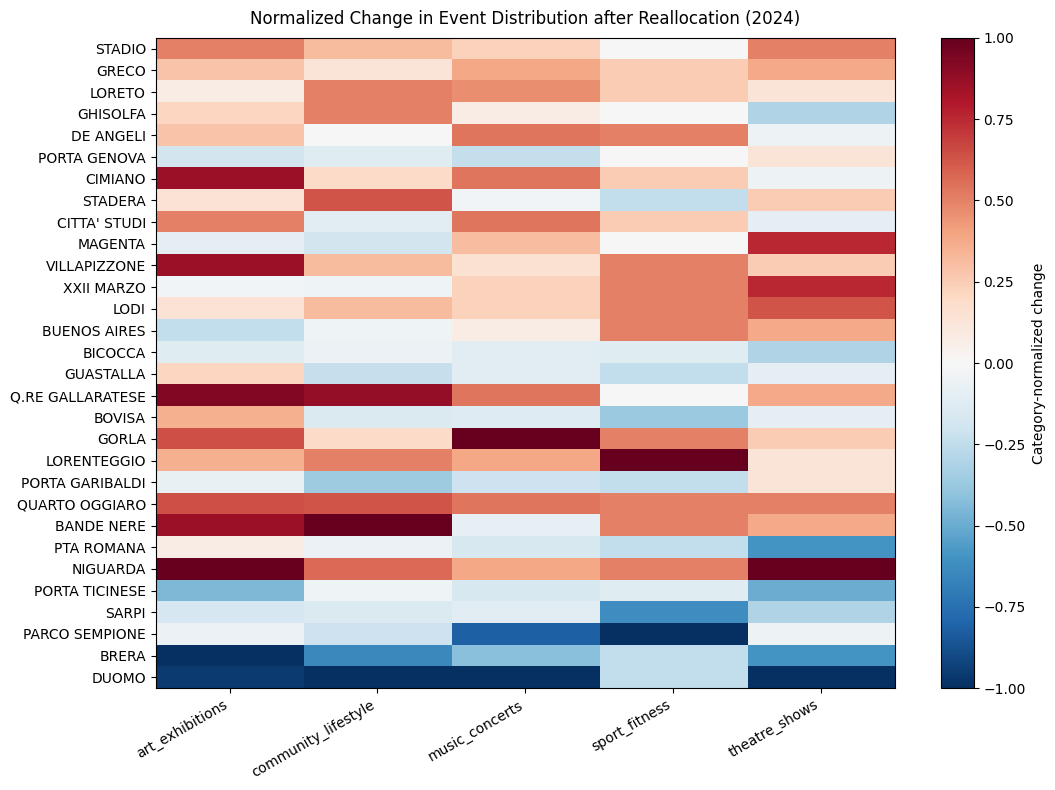

In [ ]:
CATS = ["art_exhibitions","community_lifestyle","music_concerts","sport_fitness","theatre_shows"]

fig, ax  = plot_nil_category_heatmap_posneg_scaled(
    df=df_all,
    year=2024,
    categories=CATS,
    scenario_order=("real", "reallocated"),
    top_k=30,
    cmap_name="RdBu_r",
    figsize=(11, 8),
    title="Normalized Change in Event Distribution after Reallocation (2024)"
)

In [ ]:
fig.savefig(
    "matrix_relocated.png",
    dpi=300,           # ✅ PRINT QUALITY (use 600 for ultra-high)
    bbox_inches="tight"
)

In [ ]:
abs

category,art_exhibitions,community_lifestyle,music_concerts,sport_fitness,theatre_shows
NIL,,,,,
ADRIANO,0.0,1.0,0.0,0.0,0.0
AFFORI,0.0,2.0,1.0,0.0,0.0
ASSIANO,0.0,1.0,0.0,0.0,0.0
BAGGIO - Q.RE DEGLI OLMI - Q.RE VALSESIA,0.0,0.0,0.0,0.0,1.0
BANDE NERE,0.0,0.0,8.0,0.0,1.0
...,...,...,...,...,...
TRIULZO SUPERIORE,0.0,0.0,0.0,0.0,0.0
UMBRIA - MOLISE - CALVAIRATE,2.0,1.0,0.0,0.0,4.0
VIGENTINO - Q.RE FATIMA,0.0,0.0,0.0,0.0,1.0


In [ ]:
nils = gpd.read_file('/content/NIL_WM.shp')

In [ ]:
import pickle

with open('/content/initial_state_no_big.pkl','rb') as f:
  real =pickle.load(f)

with open('/content/realloc_2024.pkl','rb') as f:
  realloc_2024 =pickle.load(f)

In [ ]:
real

,Unnamed: 0,title,location,price,category,date,weekday,opening_hour,closing_hour,url,...,SHP_Z_MIN,SHP_Z_MED,SHP_Z_MAX,S5000,S10000,FileAti,SHAPE_Leng,SHAPE_Area,Dettaglio,event_id
0,94,L'arte del gelato festeggia l’inizio dell’esta...,Grom Piazza Gae Aulenti,gratis,community_lifestyle,2024-06-13,giovedi,17:00,NaN,https://www.milanotoday.it/eventi/festa-gelato...,...,0.0,0.0,0.0,None,None,Comune,108919.88233,1.817655e+08,Comune,1
1,97,Job Meeting MILANO: le grandi aziende pronte a...,BASE Milano Via Ambrogio Bergognone da Fossano...,gratis,community_lifestyle,2024-10-30,mercoledi,09:30,16:30,https://www.milanotoday.it/eventi/job-meeting-...,...,0.0,0.0,0.0,None,None,Comune,108919.88233,1.817655e+08,Comune,2
2,1072,"Palestra FitMi di Milano, come avere abbonamen...","Palazzo Lombardia Via Luigi Galvani, 23",non disponibile,sport_fitness,2024-01-01,lunedi,07:00,22:30,https://www.milanotoday.it/eventi/offerta-pale...,...,0.0,0.0,0.0,None,None,Comune,108919.88233,1.817655e+08,Comune,3
370,3667,El Juicio del regista Ulises De La Orden,"Ariosto Spaziocinema Via Lodovico Ariosto, 16",gratis,art_exhibitions,2024-01-01,lunedi,19:40,NaN,https://www.milanotoday.it/eventi/proiezione-d...,...,0.0,0.0,0.0,None,None,Comune,108919.88233,1.817655e+08,Comune,4
409,8686,La maxi mostra di Van Gogh a Milano,Mudec - Museo delle Culture,a pagamento,art_exhibitions,2024-01-01,lunedi,14:30,19:30,https://www.milanotoday.it/eventi/mostra-van-g...,...,0.0,0.0,0.0,None,None,Comune,108919.88233,1.817655e+08,Comune,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12456,25201,Serata karaoke al Sequoia,"SEQUOIA MILANO Via Camillo Finocchiaro Aprile, 9a",gratis,music_concerts,2024-12-12,giovedi,19:30,NaN,https://www.milanotoday.it/eventi/serata-karao...,...,0.0,0.0,0.0,None,None,Comune,108919.88233,1.817655e+08,Comune,1324
12458,25203,A constructed world. The development of a voice,"Erratum Viale Andrea Doria, 20",gratis,art_exhibitions,2024-12-03,martedi,19:00,NaN,https://www.milanotoday.it/eventi/a-constructe...,...,0.0,0.0,0.0,None,None,Comune,108919.88233,1.817655e+08,Comune,1325
12461,25206,Tarocchi d'artista: le acqueforti di Mercedes ...,Galleria Manifiesto Blanco Via Benedetto Marce...,gratis,art_exhibitions,2024-12-19,giovedi,18:30,NaN,https://www.milanotoday.it/eventi/tarocchi-d-a...,...,0.0,0.0,0.0,None,None,Comune,108919.88233,1.817655e+08,Comune,1326
12464,25209,Mostra “1914. Qualcosa di nuovo sul fronte occ...,"Istituto Gonzaga Via Vitruvio, 41",gratis,art_exhibitions,2024-12-02,lunedi,16:30,19:30,https://www.milanotoday.it/eventi/mostra-1914-...,...,0.0,0.0,0.0,None,None,Comune,108919.88233,1.817655e+08,Comune,1327


In [ ]:
realloc_merged = realloc_2024.merge(hex_to_nil, how='left', left_on='assigned_cell_id', right_on='hex_id')

In [ ]:
realloc_merged

,event_id,category,assigned_cell_id,chosen_from_hub,is_fixed,hex_id_x,geometry_x,population_x,Unnamed: 0,hex_id_y,geometry_y,population_y,ID_NIL,NIL
0,1,community_lifestyle,1464,889,False,1464,POINT (9.14601 45.46771),1712.377563,1464,1464,POINT (511396.1863560004 5034834.30267674),1712.377563,52,BANDE NERE
1,2,community_lifestyle,850,889,False,850,POINT (9.15753 45.46614),1688.748535,850,850,POINT (512296.74602872686 5034662.483423533),1688.748535,51,PORTA MAGENTA
2,3,sport_fitness,1609,889,False,1609,POINT (9.16588 45.47233),1629.088867,1609,1609,POINT (512948.4096709142 5035351.420679726),1629.088867,68,PAGANO
3,4,art_exhibitions,1297,889,False,1297,POINT (9.15436 45.4739),1740.841797,1297,1297,POINT (512047.8316896876 5035523.210586199),1740.841797,58,DE ANGELI - MONTE ROSA
4,5,art_exhibitions,53,1214,False,53,POINT (9.21206 45.48489),1863.569702,53,53,POINT (516554.2166554034 5036754.91730774),1863.569702,21,BUENOS AIRES - PORTA VENEZIA - PORTA MONFORTE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1323,1324,music_concerts,1308,892,False,1308,POINT (9.0981 45.48988),100.553040,1308,1308,POINT (507647.65722654114 5037291.7291841805),100.553040,88,PARCO BOSCO IN CITTA'
1324,1325,art_exhibitions,557,1718,False,557,POINT (9.18443 45.46877),1669.491211,557,557,POINT (514399.3265189741 5034958.46655487),1669.491211,2,BRERA
1325,1326,art_exhibitions,1614,938,False,1614,POINT (9.23632 45.47112),1205.146851,1614,1614,POINT (518454.65792897897 5035230.687026113),1205.146851,22,CITTA' STUDI
1326,1327,art_exhibitions,687,847,False,687,POINT (9.11858 45.4892),1022.523926,687,687,POINT (509248.4266342442 5037218.730403437),1022.523926,65,Q.RE GALLARATESE - Q.RE SAN LEONARDO - LAMPUGNANO


In [ ]:
real = real.drop(columns=['index_right'])


/usr/local/lib/python3.12/dist-packages/geopandas/geodataframe.py:2560: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:6707
Right CRS: EPSG:4326

  return geopandas.sjoin(


In [ ]:
real.to_crs(epsg=4326, inplace=True)
real_merged = real.sjoin(nils, how='left', predicate='within')

In [ ]:
import pandas as pd
new = pd.read_csv('/content/calculate_new_stats_on_this.csv')

In [ ]:
baseline = pd.read_csv('/content/filtered_2024_no_big.csv')

In [ ]:
df_first = baseline.drop_duplicates(subset="title", keep="first")


In [ ]:
new

,Unnamed: 0.1,geometry_x,hex_id,art_exhibitions_steps,community_lifestyle_steps,music_concerts_steps,sport_fitness_steps,theatre_shows_steps,reachable_pois,art_exhibitions_reachable,...,art_exhibitions_presence,community_lifestyle_presence,music_concerts_presence,sport_fitness_presence,theatre_shows_presence,Unnamed: 0,geometry_y,population,ID_NIL,NIL
0,0,POLYGON ((1021449.5572830369 5700776.513670506...,0,1.0,1.0,1.0,4.0,0.0,27,1,...,0,0,0,0,1,0,POINT (513553.9409108793 5038720.756163063),1440.385254,79,DERGANO
1,1,"POLYGON ((1011095.4911130494 5694638.69182853,...",1,2.0,1.0,1.0,3.0,3.0,10,1,...,0,0,0,0,0,1,POINT (506291.8657683386 5034414.267670033),376.398956,55,BAGGIO - Q.RE DEGLI OLMI - Q.RE VALSESIA
2,2,POLYGON ((1025375.5089702874 5689662.960207667...,2,2.0,2.0,2.0,4.0,2.0,3,1,...,0,0,0,0,0,2,POINT (516696.5249359891 5030801.299464296),33.172318,85,PARCO DELLE ABBAZIE
3,3,"POLYGON ((1030267.4085493913 5694746.06430419,...",3,2.0,2.0,2.0,3.0,4.0,0,0,...,0,0,0,0,0,3,POINT (519755.6509254522 5034517.755055583),62.907597,24,PARCO FORLANINI - CAVRIANO
4,4,POLYGON ((1009000.3649068574 5692496.963541416...,4,7.0,1.0,5.0,9.0,1.0,3,0,...,0,0,0,0,0,4,POINT (505188.26692566735 5032766.171335073),105.727524,87,ASSIANO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1736,1736,POLYGON ((1029719.8130297873 5688983.899807937...,1736,2.0,2.0,2.0,6.0,5.0,1,1,...,0,0,0,0,0,1736,POINT (519550.69714982825 5030605.1227824455),155.876297,32,TRIULZO SUPERIORE
1737,1737,POLYGON ((1022721.0334395199 5697540.492715638...,1737,1.0,1.0,2.0,0.0,3.0,33,1,...,0,0,0,1,0,1737,POINT (514801.9501299374 5036508.169292491),1316.164185,9,PORTA GARIBALDI - PORTA NUOVA
1738,1738,"POLYGON ((1024785.197612565 5684464.769707474,...",1738,10.0,11.0,10.0,11.0,6.0,0,0,...,0,0,0,0,0,1738,POINT (516291.0654807675 5027158.553687315),82.717606,39,QUINTOSOLE
1739,1739,POLYGON ((1022971.1128864111 5688192.744730092...,1739,3.0,3.0,3.0,4.0,4.0,0,0,...,0,0,0,0,0,1739,POINT (514642.4573359649 5029914.902871941),13.354822,85,PARCO DELLE ABBAZIE


In [ ]:
df_first

,Unnamed: 0,title,location,price,category,date,weekday,opening_hour,closing_hour,url,coordinates,geometry
0,94,L'arte del gelato festeggia l’inizio dell’esta...,Grom Piazza Gae Aulenti,gratis,community_lifestyle,2024-06-13,giovedi,17:00,NaN,https://www.milanotoday.it/eventi/festa-gelato...,"(45.4830331, 9.191166899999999)",POINT (9.191166899999999 45.4830331)
1,97,Job Meeting MILANO: le grandi aziende pronte a...,BASE Milano Via Ambrogio Bergognone da Fossano...,gratis,community_lifestyle,2024-10-30,mercoledi,09:30,16:30,https://www.milanotoday.it/eventi/job-meeting-...,"(45.4524224, 9.164232199999999)",POINT (9.164232199999999 45.4524224)
2,1072,"Palestra FitMi di Milano, come avere abbonamen...","Palazzo Lombardia Via Luigi Galvani, 23",non disponibile,sport_fitness,2024-01-01,lunedi,07:00,22:30,https://www.milanotoday.it/eventi/offerta-pale...,"(45.4872986, 9.1966138)",POINT (9.1966138 45.4872986)
368,1931,Disallineamento dentale? Arriva l'apparecchio ...,Humanitas Dental Center Via Alessandro Manzoni...,non disponibile,community_lifestyle,2024-03-28,giovedi,09:00,19:00,https://www.milanotoday.it/eventi/allineatori-...,"(45.3741417, 9.165726399999999)",POINT (9.165726399999999 45.3741417)
369,2340,Un sorriso sano e luminoso? Scopri i vantaggi ...,Humanitas Dental Center Via Alessandro Manzoni...,non disponibile,community_lifestyle,2024-05-11,sabato,09:00,17:00,https://www.milanotoday.it/eventi/open-day-den...,"(45.3741417, 9.165726399999999)",POINT (9.165726399999999 45.3741417)
...,...,...,...,...,...,...,...,...,...,...,...,...
12456,25201,Serata karaoke al Sequoia,"SEQUOIA MILANO Via Camillo Finocchiaro Aprile, 9a",gratis,music_concerts,2024-12-12,giovedi,19:30,NaN,https://www.milanotoday.it/eventi/serata-karao...,"(45.4783547, 9.2003474)",POINT (9.2003474 45.4783547)
12458,25203,A constructed world. The development of a voice,"Erratum Viale Andrea Doria, 20",gratis,art_exhibitions,2024-12-03,martedi,19:00,NaN,https://www.milanotoday.it/eventi/a-constructe...,"(45.4853336, 9.2114239)",POINT (9.2114239 45.4853336)
12461,25206,Tarocchi d'artista: le acqueforti di Mercedes ...,Galleria Manifiesto Blanco Via Benedetto Marce...,gratis,art_exhibitions,2024-12-19,giovedi,18:30,NaN,https://www.milanotoday.it/eventi/tarocchi-d-a...,"(45.48299, 9.2105874)",POINT (9.2105874 45.48299)
12464,25209,Mostra “1914. Qualcosa di nuovo sul fronte occ...,"Istituto Gonzaga Via Vitruvio, 41",gratis,art_exhibitions,2024-12-02,lunedi,16:30,19:30,https://www.milanotoday.it/eventi/mostra-1914-...,"(45.4825882, 9.2060602)",POINT (9.2060602 45.4825882)


In [ ]:
baseline

,Unnamed: 0,title,location,price,category,date,weekday,opening_hour,closing_hour,url,coordinates,geometry
0,94,L'arte del gelato festeggia l’inizio dell’esta...,Grom Piazza Gae Aulenti,gratis,community_lifestyle,2024-06-13,giovedi,17:00,NaN,https://www.milanotoday.it/eventi/festa-gelato...,"(45.4830331, 9.191166899999999)",POINT (9.191166899999999 45.4830331)
1,97,Job Meeting MILANO: le grandi aziende pronte a...,BASE Milano Via Ambrogio Bergognone da Fossano...,gratis,community_lifestyle,2024-10-30,mercoledi,09:30,16:30,https://www.milanotoday.it/eventi/job-meeting-...,"(45.4524224, 9.164232199999999)",POINT (9.164232199999999 45.4524224)
2,1072,"Palestra FitMi di Milano, come avere abbonamen...","Palazzo Lombardia Via Luigi Galvani, 23",non disponibile,sport_fitness,2024-01-01,lunedi,07:00,22:30,https://www.milanotoday.it/eventi/offerta-pale...,"(45.4872986, 9.1966138)",POINT (9.1966138 45.4872986)
3,1073,"Palestra FitMi di Milano, come avere abbonamen...","Palazzo Lombardia Via Luigi Galvani, 23",non disponibile,sport_fitness,2024-01-02,martedi,07:00,22:30,https://www.milanotoday.it/eventi/offerta-pale...,"(45.4872986, 9.1966138)",POINT (9.1966138 45.4872986)
4,1074,"Palestra FitMi di Milano, come avere abbonamen...","Palazzo Lombardia Via Luigi Galvani, 23",non disponibile,sport_fitness,2024-01-03,mercoledi,07:00,22:30,https://www.milanotoday.it/eventi/offerta-pale...,"(45.4872986, 9.1966138)",POINT (9.1966138 45.4872986)
...,...,...,...,...,...,...,...,...,...,...,...,...
12488,25233,"wanted, miky degni","Centro culturale Bagutta Arte Corso Garibaldi, 19",gratis,art_exhibitions,2024-12-25,mercoledi,10:00,19:00,https://www.milanotoday.it/eventi/wanted-miky-...,"(45.4729606, 9.1833445)",POINT (9.1833445 45.4729606)
12489,25234,"wanted, miky degni","Centro culturale Bagutta Arte Corso Garibaldi, 19",gratis,art_exhibitions,2024-12-26,giovedi,10:00,19:00,https://www.milanotoday.it/eventi/wanted-miky-...,"(45.4729606, 9.1833445)",POINT (9.1833445 45.4729606)
12490,25235,"wanted, miky degni","Centro culturale Bagutta Arte Corso Garibaldi, 19",gratis,art_exhibitions,2024-12-27,venerdi,10:00,19:00,https://www.milanotoday.it/eventi/wanted-miky-...,"(45.4729606, 9.1833445)",POINT (9.1833445 45.4729606)
12491,25236,"wanted, miky degni","Centro culturale Bagutta Arte Corso Garibaldi, 19",gratis,art_exhibitions,2024-12-28,sabato,10:00,19:00,https://www.milanotoday.it/eventi/wanted-miky-...,"(45.4729606, 9.1833445)",POINT (9.1833445 45.4729606)


In [ ]:
real_merged

,Unnamed: 0,title,location,price,category,date,weekday,opening_hour,closing_hour,url,...,event_id,index_right,ID_NIL,NIL,Valido_dal,Valido_al,Fonte,Shape_Leng,Shape_Area,OBJECTID_right
0,94,L'arte del gelato festeggia l’inizio dell’esta...,Grom Piazza Gae Aulenti,gratis,community_lifestyle,2024-06-13,giovedi,17:00,NaN,https://www.milanotoday.it/eventi/festa-gelato...,...,1,68,9,PORTA GARIBALDI - PORTA NUOVA,05/02/2020,Vigente,Milano 2030 - PGT Approvato,4451.925002,7.856384e+05,157
1,97,Job Meeting MILANO: le grandi aziende pronte a...,BASE Milano Via Ambrogio Bergognone da Fossano...,gratis,community_lifestyle,2024-10-30,mercoledi,09:30,16:30,https://www.milanotoday.it/eventi/job-meeting-...,...,2,77,50,PORTA GENOVA,05/02/2020,Vigente,Milano 2030 - PGT Approvato,4121.169470,9.967487e+05,166
2,1072,"Palestra FitMi di Milano, come avere abbonamen...","Palazzo Lombardia Via Luigi Galvani, 23",non disponibile,sport_fitness,2024-01-01,lunedi,07:00,22:30,https://www.milanotoday.it/eventi/offerta-pale...,...,3,68,9,PORTA GARIBALDI - PORTA NUOVA,05/02/2020,Vigente,Milano 2030 - PGT Approvato,4451.925002,7.856384e+05,157
370,3667,El Juicio del regista Ulises De La Orden,"Ariosto Spaziocinema Via Lodovico Ariosto, 16",gratis,art_exhibitions,2024-01-01,lunedi,19:40,NaN,https://www.milanotoday.it/eventi/proiezione-d...,...,4,79,7,MAGENTA - S. VITTORE,05/02/2020,Vigente,Milano 2030 - PGT Approvato,5492.852406,1.390094e+06,168
409,8686,La maxi mostra di Van Gogh a Milano,Mudec - Museo delle Culture,a pagamento,art_exhibitions,2024-01-01,lunedi,14:30,19:30,https://www.milanotoday.it/eventi/mostra-van-g...,...,5,77,50,PORTA GENOVA,05/02/2020,Vigente,Milano 2030 - PGT Approvato,4121.169470,9.967487e+05,166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12456,25201,Serata karaoke al Sequoia,"SEQUOIA MILANO Via Camillo Finocchiaro Aprile, 9a",gratis,music_concerts,2024-12-12,giovedi,19:30,NaN,https://www.milanotoday.it/eventi/serata-karao...,...,1324,72,10,STAZIONE CENTRALE - PONTE SEVESO,05/02/2020,Vigente,Milano 2030 - PGT Approvato,7503.351720,1.556019e+06,161
12458,25203,A constructed world. The development of a voice,"Erratum Viale Andrea Doria, 20",gratis,art_exhibitions,2024-12-03,martedi,19:00,NaN,https://www.milanotoday.it/eventi/a-constructe...,...,1325,70,21,BUENOS AIRES - PORTA VENEZIA - PORTA MONFORTE,05/02/2020,Vigente,Milano 2030 - PGT Approvato,7011.870187,2.877434e+06,159
12461,25206,Tarocchi d'artista: le acqueforti di Mercedes ...,Galleria Manifiesto Blanco Via Benedetto Marce...,gratis,art_exhibitions,2024-12-19,giovedi,18:30,NaN,https://www.milanotoday.it/eventi/tarocchi-d-a...,...,1326,70,21,BUENOS AIRES - PORTA VENEZIA - PORTA MONFORTE,05/02/2020,Vigente,Milano 2030 - PGT Approvato,7011.870187,2.877434e+06,159
12464,25209,Mostra “1914. Qualcosa di nuovo sul fronte occ...,"Istituto Gonzaga Via Vitruvio, 41",gratis,art_exhibitions,2024-12-02,lunedi,16:30,19:30,https://www.milanotoday.it/eventi/mostra-1914-...,...,1327,72,10,STAZIONE CENTRALE - PONTE SEVESO,05/02/2020,Vigente,Milano 2030 - PGT Approvato,7503.351720,1.556019e+06,161


In [ ]:
nils.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
real_merged

,Unnamed: 0,title,location,price,category,date,weekday,opening_hour,closing_hour,url,...,event_id,index_right,ID_NIL,NIL,Valido_dal,Valido_al,Fonte,Shape_Leng,Shape_Area,OBJECTID_right
0,94,L'arte del gelato festeggia l’inizio dell’esta...,Grom Piazza Gae Aulenti,gratis,community_lifestyle,2024-06-13,giovedi,17:00,NaN,https://www.milanotoday.it/eventi/festa-gelato...,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,97,Job Meeting MILANO: le grandi aziende pronte a...,BASE Milano Via Ambrogio Bergognone da Fossano...,gratis,community_lifestyle,2024-10-30,mercoledi,09:30,16:30,https://www.milanotoday.it/eventi/job-meeting-...,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1072,"Palestra FitMi di Milano, come avere abbonamen...","Palazzo Lombardia Via Luigi Galvani, 23",non disponibile,sport_fitness,2024-01-01,lunedi,07:00,22:30,https://www.milanotoday.it/eventi/offerta-pale...,...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
370,3667,El Juicio del regista Ulises De La Orden,"Ariosto Spaziocinema Via Lodovico Ariosto, 16",gratis,art_exhibitions,2024-01-01,lunedi,19:40,NaN,https://www.milanotoday.it/eventi/proiezione-d...,...,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
409,8686,La maxi mostra di Van Gogh a Milano,Mudec - Museo delle Culture,a pagamento,art_exhibitions,2024-01-01,lunedi,14:30,19:30,https://www.milanotoday.it/eventi/mostra-van-g...,...,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12456,25201,Serata karaoke al Sequoia,"SEQUOIA MILANO Via Camillo Finocchiaro Aprile, 9a",gratis,music_concerts,2024-12-12,giovedi,19:30,NaN,https://www.milanotoday.it/eventi/serata-karao...,...,1324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12458,25203,A constructed world. The development of a voice,"Erratum Viale Andrea Doria, 20",gratis,art_exhibitions,2024-12-03,martedi,19:00,NaN,https://www.milanotoday.it/eventi/a-constructe...,...,1325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12461,25206,Tarocchi d'artista: le acqueforti di Mercedes ...,Galleria Manifiesto Blanco Via Benedetto Marce...,gratis,art_exhibitions,2024-12-19,giovedi,18:30,NaN,https://www.milanotoday.it/eventi/tarocchi-d-a...,...,1326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12464,25209,Mostra “1914. Qualcosa di nuovo sul fronte occ...,"Istituto Gonzaga Via Vitruvio, 41",gratis,art_exhibitions,2024-12-02,lunedi,16:30,19:30,https://www.milanotoday.it/eventi/mostra-1914-...,...,1327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
nils

,ID_NIL,NIL,Valido_dal,Valido_al,Fonte,Shape_Leng,Shape_Area,OBJECTID,geometry
0,48,RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO,05/02/2020,Vigente,Milano 2030 - PGT Approvato,8723.368714,2.406306e+06,89,"POLYGON ((9.15422 45.43775, 9.15419 45.43707, ..."
1,64,TRENNO,05/02/2020,Vigente,Milano 2030 - PGT Approvato,3309.998800,4.896921e+05,90,"POLYGON ((9.10623 45.49016, 9.10295 45.48939, ..."
2,67,PORTELLO,05/02/2020,Vigente,Milano 2030 - PGT Approvato,3800.750663,9.096022e+05,91,"POLYGON ((9.15636 45.48785, 9.15724 45.48721, ..."
3,81,BOVISASCA,05/02/2020,Vigente,Milano 2030 - PGT Approvato,7105.469715,1.578028e+06,92,"POLYGON ((9.16803 45.52234, 9.16687 45.52027, ..."
4,84,PARCO NORD,05/02/2020,Vigente,Milano 2030 - PGT Approvato,11741.717005,1.532331e+06,93,"POLYGON ((9.2004 45.52848, 9.20055 45.52828, 9..."
...,...,...,...,...,...,...,...,...,...
83,68,PAGANO,05/02/2020,Vigente,Milano 2030 - PGT Approvato,5221.836696,1.289686e+06,172,"POLYGON ((9.17174 45.47619, 9.1715 45.47595, 9..."
84,2,BRERA,05/02/2020,Vigente,Milano 2030 - PGT Approvato,5461.667196,1.637333e+06,173,"POLYGON ((9.19165 45.46906, 9.19105 45.46843, ..."
85,33,ROGOREDO - SANTA GIULIA,05/02/2020,Vigente,Milano 2030 - PGT Approvato,6012.496435,1.200116e+06,174,"POLYGON ((9.24044 45.44427, 9.24084 45.44424, ..."
86,17,ADRIANO,05/02/2020,Vigente,Milano 2030 - PGT Approvato,9276.875747,2.433358e+06,175,"POLYGON ((9.26729 45.51234, 9.26701 45.51241, ..."


In [ ]:
import pandas as pd
hex_to_nil = pd.read_csv('/content/hex_to_nil.csv')

In [ ]:
with open('/content/cityscore_pw_mean_2024_real.pkl', 'rb') as f:
  pw_mean_24_real = pickle.load(f)

with open('/content/cityscore_pw_mean_2024_alloc.pkl', 'rb') as f:
  pw_mean_24_alloc = pickle.load(f)

In [ ]:
with open('/content/2023_cityscore_pw_mean.pkl', 'rb') as f:
  pw_mean_23_real = pickle.load(f)

In [ ]:
import pandas as pd
import numpy as np

def compute_tertiles_from_df(df: pd.DataFrame, cols: list[str]) -> dict:
    """
    Compute tertile thresholds for multiple columns in a DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame.
    cols : list of str
        Column names to compute tertiles for.

    Returns
    -------
    thresholds : dict
        {col_name: (q1, q2)} dictionary with tertile thresholds.
    """
    thresholds = {}
    for col in cols:
        s = df[col].dropna()
        q1, q2 = s.quantile([1/3, 2/3], interpolation='linear').values
        thresholds[col] = (q1, q2)
    return thresholds


def apply_tertiles(df: pd.DataFrame, thresholds: dict, suffix: str = "_bin") -> pd.DataFrame:
    """
    Apply precomputed tertile thresholds to assign bins (0,1,2) to new DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame where bins should be assigned.
    thresholds : dict
        Output from `compute_tertiles_from_df`, e.g. {"cityscore_pw_mean": (q1, q2), "pop_total": (q1, q2)}.
    suffix : str, default="_bin"
        Suffix added to column names for the new bin columns.

    Returns
    -------
    df_out : pd.DataFrame
        Copy of input df with new bin columns added.
    """
    df_out = df.copy()
    for col, (q1, q2) in thresholds.items():
        new_col = f"{col}{suffix}"
        bins = pd.Series(pd.NA, index=df_out.index, dtype="Int64")
        bins.loc[df_out[col] <= q1] = 0
        bins.loc[(df_out[col] > q1) & (df_out[col] <= q2)] = 1
        bins.loc[df_out[col] > q2] = 2
        df_out[new_col] = bins
    return df_out



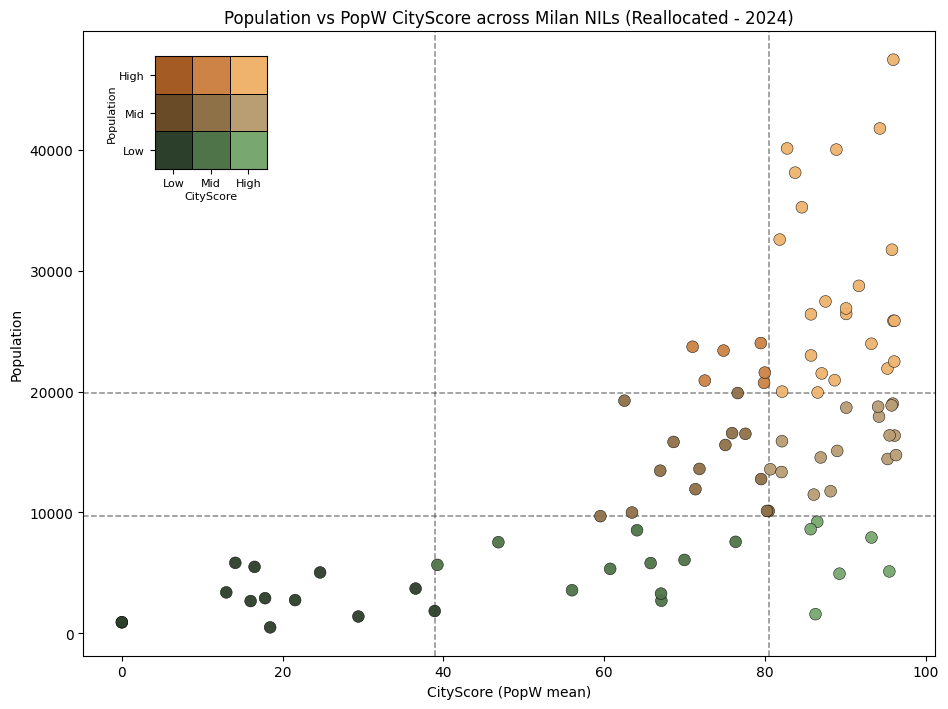

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# =========================
# CONFIG
# =========================
cube_mode   = "manual"                 # "loc" | "anchor" | "manual"
cube_size   = ("18%", "18%")
cube_loc    = "upper left"
cube_anchor = (0.20, 0.20)
cube_bounds = [0.06, 0.78, 0.18, 0.18] # [x0,y0,w,h] in axes fraction

PALETTE_NAME = "green_orange"           # "teal_purple" | "blue_red" | "green_orange"

DOT_SIZE   = 72
EDGE_LW    = 0.35
GRID_LW    = 1.1
GRID_ALPHA = 0.6

# =========================
# INPUTS
# =========================
# Set your reference df (where tertiles are computed) and your target df (where tertiles are applied)
df_ref       = pw_mean_24_real         # <- change to your reference dataset
df_target    = reloc_2024        # <- change to your target dataset

xcol = 'cityscore_pw_mean'      # CityScore
ycol = 'pop_total'              # Population
name_col = 'NIL'

# =========================
# Bivariate palette (3×3, row-major: pop row × score col)
# =========================
def bivariate_palette(name="teal_purple"):
    palettes = {
        "teal_purple": [
            "#2b3f46", "#3e6d75", "#5fa3aa",
            "#503a5a", "#6d5c85", "#9a8fbe",
            "#7b4a8e", "#a06db2", "#caa6d8",
        ],
        "blue_red": [
            "#2b3a67", "#3d59a6", "#5d82cf",
            "#6b3a54", "#8e5c74", "#b8829b",
            "#9a3a3a", "#c25b4f", "#e38a73",
        ],
        "green_orange": [
            "#2c3f2a", "#4f7449", "#78a770",
            "#6a4b27", "#8f7147", "#b99d73",
            "#a55c24", "#cc8345", "#efb36e",
        ],
    }
    return palettes[name]

PALETTE_3x3 = bivariate_palette(PALETTE_NAME)

# =========================
# Helpers
# =========================
def add_bivariate_cube_inset(ax,
                             palette9,
                             width="26%", height="26%",
                             loc="upper right",
                             bbox_to_anchor=None,
                             bbox_transform=None,
                             manual_bounds=None,
                             label_x="CityScore",
                             label_y="Population"):
    if manual_bounds is not None:
        inax = ax.inset_axes(manual_bounds)
    else:
        if (isinstance(width, str) and "%" in width) or (isinstance(height, str) and "%" in height):
            if isinstance(bbox_to_anchor, (tuple, list)) and len(bbox_to_anchor) == 2:
                bbox_to_anchor = (*bbox_to_anchor, 1, 1)
                if bbox_transform is None:
                    bbox_transform = ax.transAxes
        inax = inset_axes(ax, width=width, height=height, loc=loc,
                          bbox_to_anchor=bbox_to_anchor, bbox_transform=bbox_transform,
                          borderpad=0.8)
    inax.set_aspect("equal")
    for pbin in range(3):
        for sbin in range(3):
            idx = pbin*3 + sbin   # row-major
            r = Rectangle((sbin, pbin), 1, 1,
                          facecolor=palette9[idx], edgecolor="k", linewidth=0.6)
            inax.add_patch(r)
    inax.set_xlim(0, 3); inax.set_ylim(0, 3)
    inax.set_xticks([0.5, 1.5, 2.5]); inax.set_yticks([0.5, 1.5, 2.5])
    inax.set_xticklabels(["Low", "Mid", "High"], fontsize=8)
    inax.set_yticklabels(["Low", "Mid", "High"], fontsize=8)
    for v in [1, 2]:
        inax.axvline(v, color='k', lw=0.6); inax.axhline(v, color='k', lw=0.6)
    inax.set_xlabel(label_x, fontsize=8, labelpad=2)
    inax.set_ylabel(label_y, fontsize=8, labelpad=2)
    for s in inax.spines.values(): s.set_linewidth(0.8)
    return inax

# =========================
# Prep: compute tertiles on reference and apply to target
# (uses the helper functions you already defined earlier)
# =========================
cols = [xcol, ycol]
tertiles_ref = compute_tertiles_from_df(df_ref, cols)        # {col: (q1, q2)}
df_binned    = apply_tertiles(df_target, tertiles_ref, "_bin")

# Pull thresholds for grid lines
s_lo, s_hi = tertiles_ref[xcol]
p_lo, p_hi = tertiles_ref[ycol]

# Grab the integer bin columns produced by apply_tertiles
s_bin = df_binned[f"{xcol}_bin"]
p_bin = df_binned[f"{ycol}_bin"]

# Bivariate color index and colors
df = df_binned.copy()
df['_sbin']  = s_bin
df['_pbin']  = p_bin
df['_bivar'] = df['_pbin'] * 3 + df['_sbin']
color_map = dict(enumerate(PALETTE_3x3))
df['_color'] = df['_bivar'].map(color_map)

# =========================
# Plot
# =========================
fig, ax = plt.subplots(figsize=(9.6, 7.2))

plot_df = df.dropna(subset=[xcol, ycol, '_color'])
ax.scatter(plot_df[xcol], plot_df[ycol],
           c=plot_df['_color'], s=DOT_SIZE,
           edgecolor='k', linewidth=EDGE_LW, alpha=0.95, zorder=2)

ax.set_xlabel("CityScore (PopW mean)")
ax.set_ylabel("Population")
ax.set_title("Population vs PopW CityScore across Milan NILs (Reallocated - 2024)")

# Draw tertile grid lines from the reference thresholds
ax.axvline(s_lo, color='0.25', lw=GRID_LW, ls='--', alpha=GRID_ALPHA, zorder=1)
ax.axvline(s_hi, color='0.25', lw=GRID_LW, ls='--', alpha=GRID_ALPHA, zorder=1)
ax.axhline(p_lo, color='0.25', lw=GRID_LW, ls='--', alpha=GRID_ALPHA, zorder=1)
ax.axhline(p_hi, color='0.25', lw=GRID_LW, ls='--', alpha=GRID_ALPHA, zorder=1)

# Inset bivariate legend
if cube_mode == "manual":
    add_bivariate_cube_inset(ax, PALETTE_3x3, manual_bounds=cube_bounds)
elif cube_mode == "anchor":
    add_bivariate_cube_inset(ax, PALETTE_3x3,
                             width=cube_size[0], height=cube_size[1],
                             loc="upper left",
                             bbox_to_anchor=cube_anchor,
                             bbox_transform=ax.transAxes)
else:
    add_bivariate_cube_inset(ax, PALETTE_3x3,
                             width=cube_size[0], height=cube_size[1],
                             loc=cube_loc)


plt.tight_layout()

fig.savefig(
    "reloc_2024.png",
    dpi=300,           # ✅ PRINT QUALITY (use 600 for ultra-high)
    bbox_inches="tight"
)

plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
hex_to_nil

,Unnamed: 0,hex_id,geometry,population,ID_NIL,NIL
0,0,0,POINT (513553.9409108793 5038720.756163063),1440.385254,79,DERGANO
1,1,1,POINT (506291.8657683386 5034414.267670033),376.398956,55,BAGGIO - Q.RE DEGLI OLMI - Q.RE VALSESIA
2,2,2,POINT (516696.5249359891 5030801.299464296),33.172318,85,PARCO DELLE ABBAZIE
3,3,3,POINT (519755.6509254522 5034517.755055583),62.907597,24,PARCO FORLANINI - CAVRIANO
4,4,4,POINT (505188.26692566735 5032766.171335073),105.727524,87,ASSIANO
...,...,...,...,...,...,...
1736,1736,1736,POINT (519550.69714982825 5030605.1227824455),155.876297,32,TRIULZO SUPERIORE
1737,1737,1737,POINT (514801.9501299374 5036508.169292491),1316.164185,9,PORTA GARIBALDI - PORTA NUOVA
1738,1738,1738,POINT (516291.0654807675 5027158.553687315),82.717606,39,QUINTOSOLE
1739,1739,1739,POINT (514642.4573359649 5029914.902871941),13.354822,85,PARCO DELLE ABBAZIE


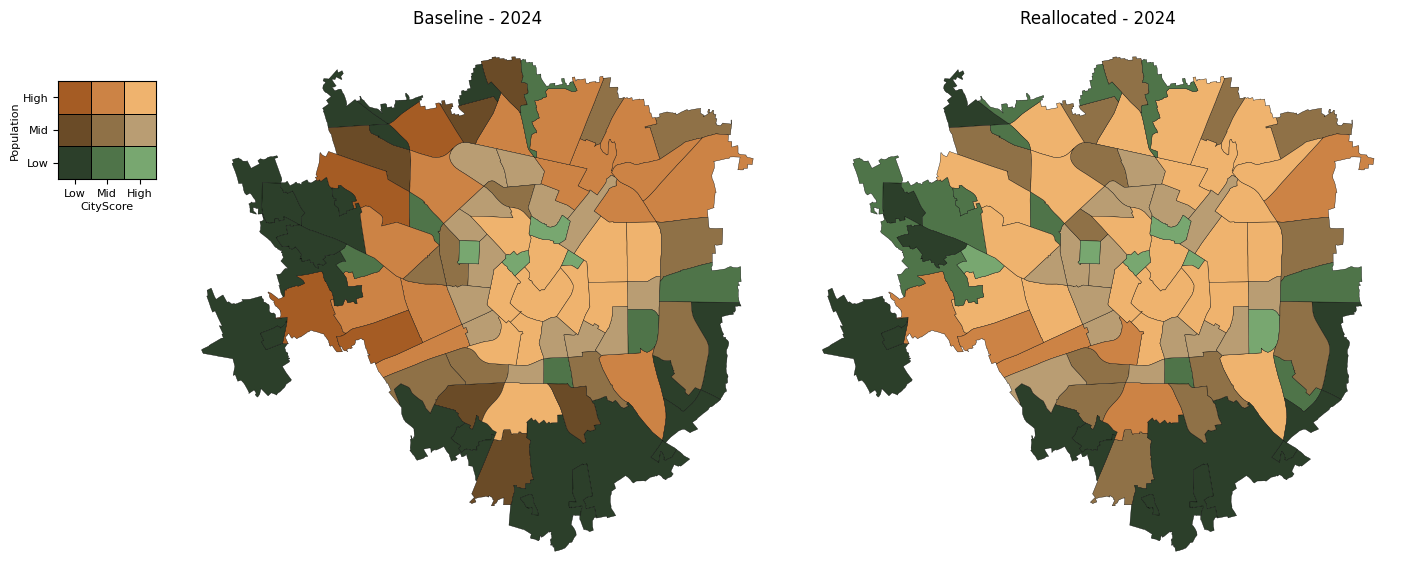

In [ ]:
import geopandas as gpd

# Force your inputs into proper GeoDataFrames
realloc_2024 = gpd.GeoDataFrame(
    pw_mean_24_alloc,
    geometry="geometry",   # must match your actual geometry column name
    crs="EPSG:4326"        # or the CRS your geometries are in
)

real_2024 = gpd.GeoDataFrame(
    pw_mean_24_real,
    geometry="geometry",
    crs="EPSG:4326"
)

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# =========================
# CONFIG
# =========================
PALETTE_NAME   = "green_orange"         # "teal_purple" | "blue_red" | "green_orange"
EDGE_LW        = 0.25
MISSING_COLOR  = "#eeeeee"
BORDER_COLOR   = "black"
BORDER_ALPHA   = 0.6

xcol = "cityscore_pw_mean"             # CityScore (x-axis metric)
ycol = "pop_total"                     # Population (y-axis metric)

cube_bounds_left = [-0.2, 0.73, 0.18, 0.18]   # [x0, y0, w, h] in axes fraction
PALETTE_TOP_LEFT_FIRST = False   # True = top row = high population


# =========================
# 3×3 Bivariate palette
# =========================
def bivariate_palette(name="teal_purple"):
    palettes = {
        "teal_purple": [
            "#2b3f46", "#3e6d75", "#5fa3aa",
            "#503a5a", "#6d5c85", "#9a8fbe",
            "#7b4a8e", "#a06db2", "#caa6d8",
        ],
        "blue_red": [
            "#2b3a67", "#3d59a6", "#5d82cf",
            "#6b3a54", "#8e5c74", "#b8829b",
            "#9a3a3a", "#c25b4f", "#e38a73",
        ],
        "green_orange": [
            "#2c3f2a", "#4f7449", "#78a770",
            "#6a4b27", "#8f7147", "#b99d73",
            "#a55c24", "#cc8345", "#efb36e",
        ],
    }
    return palettes[name]

PALETTE_3x3 = bivariate_palette(PALETTE_NAME)


# =========================
# Tertile helpers
# =========================
def compute_tertiles_from_df(df, cols):
    """
    Compute tertile thresholds (q1, q2) for each column in cols.
    Returns: {col: (q1, q2)}
    """
    out = {}
    for c in cols:
        s = df[c].dropna().values
        if len(s) == 0:
            out[c] = (np.nan, np.nan)
        else:
            q1, q2 = np.nanpercentile(s, [33.33, 66.67])
            out[c] = (q1, q2)
    return out


def bin_series_with_tertiles(s, q1, q2):
    """
    Bin a Series into 0,1,2 based on tertile thresholds.
    0 = low  (<= q1)
    1 = mid  (q1–q2)
    2 = high (> q2)
    """
    return pd.cut(
        s,
        bins=[-np.inf, q1, q2, np.inf],
        labels=[0, 1, 2]
    ).astype("Int64")


# =========================
# Palette indexing + cube
# =========================
def index_for(pbin, sbin):
    """
    Convert population bin (row) and score bin (col) into a 0–8 index.
    Flips rows if top-left-first palette is desired.
    """
    if PALETTE_TOP_LEFT_FIRST:
        return (2 - pbin) * 3 + sbin
    else:
        return pbin * 3 + sbin


def add_bivariate_cube_inset(ax, palette9, manual_bounds,
                             label_x="CityScore", label_y="Population"):
    """Draws the 3×3 legend cube inside an axis."""
    inax = ax.inset_axes(manual_bounds)
    inax.set_aspect("equal")

    for pbin in range(3):
        for sbin in range(3):
            idx = index_for(pbin, sbin)
            r = Rectangle((sbin, pbin), 1, 1,
                          facecolor=palette9[idx], edgecolor="k", linewidth=0.6)
            inax.add_patch(r)

    inax.set_xlim(0, 3); inax.set_ylim(0, 3)
    inax.set_xticks([0.5, 1.5, 2.5]); inax.set_yticks([0.5, 1.5, 2.5])
    inax.set_xticklabels(["Low", "Mid", "High"], fontsize=8)
    inax.set_yticklabels(["Low", "Mid", "High"], fontsize=8)
    for v in [1, 2]:
        inax.axvline(v, color='k', lw=0.6)
        inax.axhline(v, color='k', lw=0.6)
    inax.set_xlabel(label_x, fontsize=8, labelpad=2)
    inax.set_ylabel(label_y, fontsize=8, labelpad=2)
    for s in inax.spines.values():
        s.set_linewidth(0.8)
    return inax


# =========================
# Apply 3×3 bins and colors
# =========================
def colorize_by_bivariate_bins(gdf_target: gpd.GeoDataFrame,
                               tertiles_ref: dict,
                               xcol: str, ycol: str) -> gpd.GeoDataFrame:
    """
    Apply 3×3 tertile bins from reference thresholds and assign colors.
    Keeps geometry & CRS so GeoDataFrame.plot works.
    """
    out = gdf_target.copy()

    qx1, qx2 = tertiles_ref[xcol]
    qy1, qy2 = tertiles_ref[ycol]

    out["_sbin"] = bin_series_with_tertiles(out[xcol], qx1, qx2)  # score bin
    out["_pbin"] = bin_series_with_tertiles(out[ycol], qy1, qy2)  # population bin

    # index 0–8
    out["_bivar"] = [
        index_for(int(p), int(s)) if (pd.notna(p) and pd.notna(s)) else np.nan
        for p, s in zip(out["_pbin"], out["_sbin"])
    ]

    palette_map = dict(enumerate(PALETTE_3x3))
    out["_color"] = out["_bivar"].map(palette_map)

    # ensure it's still a GeoDataFrame
    out = gpd.GeoDataFrame(out, geometry=gdf_target.geometry.name, crs=gdf_target.crs)
    return out


# =========================
# Main plotting function
# =========================
def plot_side_by_side_maps(gdf_real: gpd.GeoDataFrame,
                           gdf_alloc: gpd.GeoDataFrame,
                           xcol: str = xcol, ycol: str = ycol,
                           left_title: str = "Baseline - 2024",
                           right_title: str = "Reallocated - 2024"):
    """
    Plots two GeoDataFrames side-by-side using the same tertile thresholds and palette.
    """
    # Make sure inputs are GeoDataFrames
    gdf_real = gpd.GeoDataFrame(gdf_real, geometry=gdf_real.geometry.name, crs=gdf_real.crs)
    gdf_alloc = gpd.GeoDataFrame(gdf_alloc, geometry=gdf_alloc.geometry.name, crs=gdf_alloc.crs)

    # 1. thresholds from REAL scenario
    tertiles_ref = compute_tertiles_from_df(gdf_real, [xcol, ycol])

    # 2. apply same thresholds to both datasets
    real_col  = colorize_by_bivariate_bins(gdf_real,  tertiles_ref, xcol, ycol)
    alloc_col = colorize_by_bivariate_bins(gdf_alloc, tertiles_ref, xcol, ycol)

    # 3. build figure
    fig, axes = plt.subplots(1, 2, figsize=(14, 7), constrained_layout=True)

    # Left = real
    ax = axes[0]
    real_col.plot(
        ax=ax,
        color=real_col["_color"].fillna(MISSING_COLOR),
        edgecolor=BORDER_COLOR,
        linewidth=EDGE_LW,
        alpha=1.0,
    )
    ax.set_title(left_title)
    ax.set_axis_off()
    add_bivariate_cube_inset(ax, PALETTE_3x3, manual_bounds=cube_bounds_left)

    # Right = reallocated
    ax = axes[1]
    alloc_col.plot(
        ax=ax,
        color=alloc_col["_color"].fillna(MISSING_COLOR),
        edgecolor=BORDER_COLOR,
        linewidth=EDGE_LW,
        alpha=1.0,
    )
    ax.set_title(right_title)
    ax.set_axis_off()

    # Ensure both maps have identical extent
    xmin, xmax = axes[0].get_xlim()
    ymin, ymax = axes[0].get_ylim()
    axes[1].set_xlim(xmin, xmax)
    axes[1].set_ylim(ymin, ymax)

    fig.savefig(
    "2024_ _reallloc_choro.png",
    dpi=300,           # ✅ PRINT QUALITY (use 600 for ultra-high)
    bbox_inches="tight"
  )

    plt.show()


# =========================
# Example usage
# =========================
plot_side_by_side_maps(pw_mean_24_real,  merge_reloc)


In [ ]:
pw_mean_24_real

,NIL,cityscore_pw_mean,pop_total,n_hex,geometry
0,ADRIANO,41.952797,13449.681480,23.0,"POLYGON ((9.26729 45.51234, 9.26701 45.51241, ..."
1,AFFORI,47.386310,20935.025116,19.0,"POLYGON ((9.17767 45.51899, 9.17796 45.51848, ..."
2,ASSIANO,11.792941,3378.342817,59.0,"POLYGON ((9.04687 45.46276, 9.04688 45.46276, ..."
3,BAGGIO - Q.RE DEGLI OLMI - Q.RE VALSESIA,23.901804,24012.770599,33.0,"POLYGON ((9.09315 45.46938, 9.09393 45.46802, ..."
4,BANDE NERE,49.461824,40026.617310,27.0,"POLYGON ((9.12727 45.46894, 9.12874 45.4684, 9..."
...,...,...,...,...,...
83,TRIULZO SUPERIORE,0.000000,2739.061113,12.0,"POLYGON ((9.26378 45.43251, 9.26384 45.43248, ..."
84,UMBRIA - MOLISE - CALVAIRATE,90.176113,16373.532349,12.0,"POLYGON ((9.22392 45.45969, 9.22392 45.45934, ..."
85,VIGENTINO - Q.RE FATIMA,29.261989,11920.605484,18.0,"POLYGON ((9.2006 45.43608, 9.20429 45.43642, 9..."
86,VILLAPIZZONE - CAGNOLA - BOLDINASCO,66.821103,41773.934113,34.0,"POLYGON ((9.16204 45.4969, 9.16012 45.4957, 9...."


,Unnamed: 0,NIL,cityscore_pw_mean_x,pop_total_x,n_hex_x,cityscore_pw_mean_y,pop_total_y,n_hex_y,geometry
0,0,ADRIANO,66.979081,13449.681480,23.0,41.952797,13449.681480,23.0,"POLYGON ((9.26729 45.51234, 9.26701 45.51241, ..."
1,1,AFFORI,88.675972,20935.025116,19.0,47.386310,20935.025116,19.0,"POLYGON ((9.17767 45.51899, 9.17796 45.51848, ..."
2,2,ASSIANO,12.988603,3378.342817,59.0,11.792941,3378.342817,59.0,"POLYGON ((9.04687 45.46276, 9.04688 45.46276, ..."
3,3,BAGGIO - Q.RE DEGLI OLMI - Q.RE VALSESIA,79.489406,24012.770599,33.0,23.901804,24012.770599,33.0,"POLYGON ((9.09315 45.46938, 9.09393 45.46802, ..."
4,4,BANDE NERE,88.889382,40026.617310,27.0,49.461824,40026.617310,27.0,"POLYGON ((9.12727 45.46894, 9.12874 45.4684, 9..."
...,...,...,...,...,...,...,...,...,...
83,83,TRIULZO SUPERIORE,21.554718,2739.061113,12.0,0.000000,2739.061113,12.0,"POLYGON ((9.26378 45.43251, 9.26384 45.43248, ..."
84,84,UMBRIA - MOLISE - CALVAIRATE,95.515818,16373.532349,12.0,90.176113,16373.532349,12.0,"POLYGON ((9.22392 45.45969, 9.22392 45.45934, ..."
85,85,VIGENTINO - Q.RE FATIMA,71.358246,11920.605484,18.0,29.261989,11920.605484,18.0,"POLYGON ((9.2006 45.43608, 9.20429 45.43642, 9..."
86,86,VILLAPIZZONE - CAGNOLA - BOLDINASCO,94.308974,41773.934113,34.0,66.821103,41773.934113,34.0,"POLYGON ((9.16204 45.4969, 9.16012 45.4957, 9...."


In [ ]:
merge_reloc = reloc_2024.merge(pw_mean_24_real,how='left',on='NIL')

pandas.core.frame.DataFrame

In [ ]:
merge_reloc = gpd.GeoDataFrame(merge_reloc, geometry='geometry', crs=4326)
pw_mean_24_real = gpd.GeoDataFrame(pw_mean_24_real, geometry='geometry', crs=4326)

In [ ]:
merge_reloc.rename(columns={'pop_total_x': 'pop_total'}, inplace = True)

In [ ]:
pw_mean_24_real

,NIL,cityscore_pw_mean,pop_total,n_hex,geometry
0,ADRIANO,41.952797,13449.681480,23.0,"POLYGON ((9.26729 45.51234, 9.26701 45.51241, ..."
1,AFFORI,47.386310,20935.025116,19.0,"POLYGON ((9.17767 45.51899, 9.17796 45.51848, ..."
2,ASSIANO,11.792941,3378.342817,59.0,"POLYGON ((9.04687 45.46276, 9.04688 45.46276, ..."
3,BAGGIO - Q.RE DEGLI OLMI - Q.RE VALSESIA,23.901804,24012.770599,33.0,"POLYGON ((9.09315 45.46938, 9.09393 45.46802, ..."
4,BANDE NERE,49.461824,40026.617310,27.0,"POLYGON ((9.12727 45.46894, 9.12874 45.4684, 9..."
...,...,...,...,...,...
83,TRIULZO SUPERIORE,0.000000,2739.061113,12.0,"POLYGON ((9.26378 45.43251, 9.26384 45.43248, ..."
84,UMBRIA - MOLISE - CALVAIRATE,90.176113,16373.532349,12.0,"POLYGON ((9.22392 45.45969, 9.22392 45.45934, ..."
85,VIGENTINO - Q.RE FATIMA,29.261989,11920.605484,18.0,"POLYGON ((9.2006 45.43608, 9.20429 45.43642, 9..."
86,VILLAPIZZONE - CAGNOLA - BOLDINASCO,66.821103,41773.934113,34.0,"POLYGON ((9.16204 45.4969, 9.16012 45.4957, 9...."


In [ ]:
reloc_2024 = pd.read_csv('/content/nil_summary_2024_reloc.csv')

In [ ]:
reloc_2024

,Unnamed: 0,NIL,cityscore_pw_mean,pop_total,n_hex
0,0,ADRIANO,66.979081,13449.681480,23.0
1,1,AFFORI,88.675972,20935.025116,19.0
2,2,ASSIANO,12.988603,3378.342817,59.0
3,3,BAGGIO - Q.RE DEGLI OLMI - Q.RE VALSESIA,79.489406,24012.770599,33.0
4,4,BANDE NERE,88.889382,40026.617310,27.0
...,...,...,...,...,...
83,83,TRIULZO SUPERIORE,21.554718,2739.061113,12.0
84,84,UMBRIA - MOLISE - CALVAIRATE,95.515818,16373.532349,12.0
85,85,VIGENTINO - Q.RE FATIMA,71.358246,11920.605484,18.0
86,86,VILLAPIZZONE - CAGNOLA - BOLDINASCO,94.308974,41773.934113,34.0


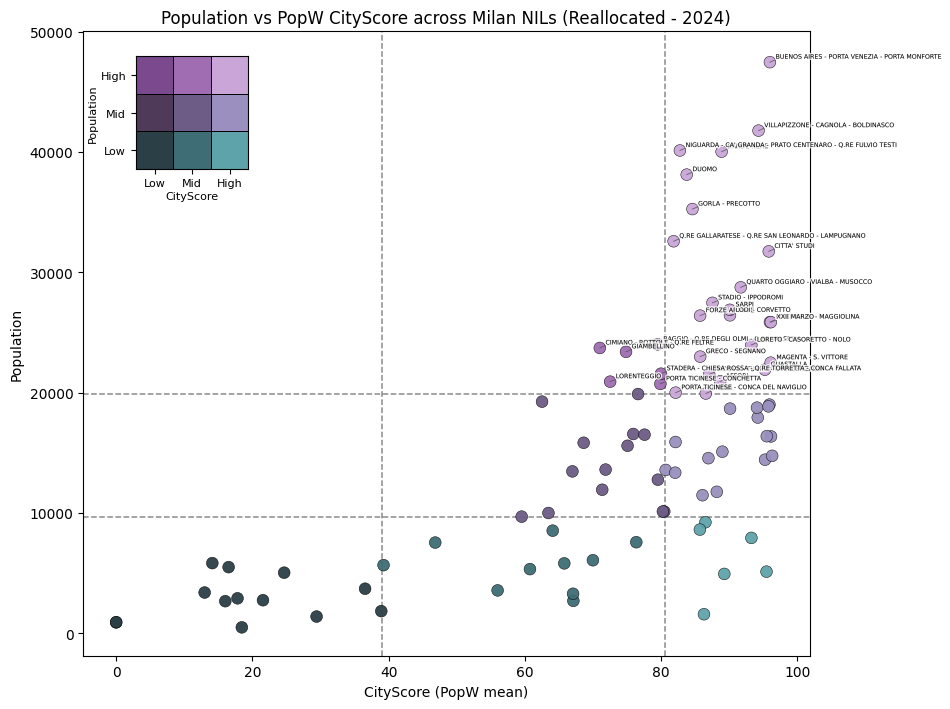

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patheffects as pe

# =========================
# CONFIG
# =========================
cube_mode   = "manual"
cube_size   = ("18%", "18%")
cube_loc    = "upper left"
cube_anchor = (0.20, 0.20)
cube_bounds = [0.06, 0.78, 0.18, 0.18]

PALETTE_NAME = "teal_purple"           # "teal_purple" | "blue_red" | "green_orange"

DOT_SIZE   = 72
EDGE_LW    = 0.35
GRID_LW    = 1.1
GRID_ALPHA = 0.6

# Label styling
LABEL_FONT_SIZE = 4.5
LABEL_X_OFFSET = 0.02
LABEL_Y_OFFSET = 0.02
LABEL_COLOR = "black"
LINE_COLOR = "0.3"
LINE_WIDTH = 0.6
LINE_ALPHA = 0.8

# =========================
# INPUTS
# =========================
df_ref       = pw_mean_24_real
df_target    = reloc_2024


xcol = 'cityscore_pw_mean'
ycol = 'pop_total'
name_col = 'NIL'

# =========================
# Palette
# =========================
def bivariate_palette(name="teal_purple"):
    palettes = {
        "teal_purple": [
            "#2b3f46", "#3e6d75", "#5fa3aa",
            "#503a5a", "#6d5c85", "#9a8fbe",
            "#7b4a8e", "#a06db2", "#caa6d8",
        ],
        "blue_red": [
            "#2b3a67", "#3d59a6", "#5d82cf",
            "#6b3a54", "#8e5c74", "#b8829b",
            "#9a3a3a", "#c25b4f", "#e38a73",
        ],
        "green_orange": [
            "#2c3f2a", "#4f7449", "#78a770",
            "#6a4b27", "#8f7147", "#b99d73",
            "#a55c24", "#cc8345", "#efb36e",
        ],
    }
    return palettes[name]

PALETTE_3x3 = bivariate_palette(PALETTE_NAME)

# =========================
# Cube inset
# =========================
def add_bivariate_cube_inset(ax, palette9, manual_bounds=None,
                             width="26%", height="26%", loc="upper right",
                             bbox_to_anchor=None, bbox_transform=None,
                             label_x="CityScore", label_y="Population"):
    if manual_bounds is not None:
        inax = ax.inset_axes(manual_bounds)
    else:
        if (isinstance(width, str) and "%" in width) or (isinstance(height, str) and "%" in height):
            if isinstance(bbox_to_anchor, (tuple, list)) and len(bbox_to_anchor) == 2:
                bbox_to_anchor = (*bbox_to_anchor, 1, 1)
                if bbox_transform is None:
                    bbox_transform = ax.transAxes
        from mpl_toolkits.axes_grid1.inset_locator import inset_axes
        inax = inset_axes(ax, width=width, height=height, loc=loc,
                          bbox_to_anchor=bbox_to_anchor, bbox_transform=bbox_transform,
                          borderpad=0.8)
    inax.set_aspect("equal")
    for pbin in range(3):
        for sbin in range(3):
            idx = pbin * 3 + sbin
            r = Rectangle((sbin, pbin), 1, 1, facecolor=palette9[idx],
                          edgecolor="k", linewidth=0.6)
            inax.add_patch(r)
    inax.set_xlim(0, 3); inax.set_ylim(0, 3)
    inax.set_xticks([0.5, 1.5, 2.5]); inax.set_yticks([0.5, 1.5, 2.5])
    inax.set_xticklabels(["Low", "Mid", "High"], fontsize=8)
    inax.set_yticklabels(["Low", "Mid", "High"], fontsize=8)
    for v in [1, 2]:
        inax.axvline(v, color='k', lw=0.6)
        inax.axhline(v, color='k', lw=0.6)
    inax.set_xlabel(label_x, fontsize=8, labelpad=2)
    inax.set_ylabel(label_y, fontsize=8, labelpad=2)
    for s in inax.spines.values(): s.set_linewidth(0.8)
    return inax

# =========================
# Prep: compute tertiles & assign bins/colors
# =========================
cols = [xcol, ycol]
tertiles_ref = compute_tertiles_from_df(df_ref, cols)
df_binned = apply_tertiles(df_target, tertiles_ref, "_bin")

s_lo, s_hi = tertiles_ref[xcol]
p_lo, p_hi = tertiles_ref[ycol]

df = df_binned.copy()
df["_sbin"] = df_binned[f"{xcol}_bin"]
df["_pbin"] = df_binned[f"{ycol}_bin"]
df["_bivar"] = df["_pbin"] * 3 + df["_sbin"]
color_map = dict(enumerate(PALETTE_3x3))
df["_color"] = df["_bivar"].map(color_map)

# =========================
# Plot
# =========================
fig, ax = plt.subplots(figsize=(9.6, 7.2))

plot_df = df.dropna(subset=[xcol, ycol, "_color"])
ax.scatter(plot_df[xcol], plot_df[ycol],
           c=plot_df["_color"], s=DOT_SIZE,
           edgecolor='k', linewidth=EDGE_LW, alpha=0.95, zorder=2)

ax.set_xlabel("CityScore (PopW mean)")
ax.set_ylabel("Population")
ax.set_title("Population vs PopW CityScore across Milan NILs (Reallocated - 2024)")

# Grid lines
ax.axvline(s_lo, color='0.25', lw=GRID_LW, ls='--', alpha=GRID_ALPHA, zorder=1)
ax.axvline(s_hi, color='0.25', lw=GRID_LW, ls='--', alpha=GRID_ALPHA, zorder=1)
ax.axhline(p_lo, color='0.25', lw=GRID_LW, ls='--', alpha=GRID_ALPHA, zorder=1)
ax.axhline(p_hi, color='0.25', lw=GRID_LW, ls='--', alpha=GRID_ALPHA, zorder=1)

# Cube
if cube_mode == "manual":
    add_bivariate_cube_inset(ax, PALETTE_3x3, manual_bounds=cube_bounds)
elif cube_mode == "anchor":
    add_bivariate_cube_inset(ax, PALETTE_3x3,
                             width=cube_size[0], height=cube_size[1],
                             loc="upper left",
                             bbox_to_anchor=cube_anchor,
                             bbox_transform=ax.transAxes)
else:
    add_bivariate_cube_inset(ax, PALETTE_3x3,
                             width=cube_size[0], height=cube_size[1],
                             loc=cube_loc)

# =========================
# Label only High–* bins (CityScore High)
# =========================
label_mask = (plot_df["_pbin"] ==2)  # High CityScore bin
labels_df = plot_df[label_mask]

# Leader lines and labels
for _, r in labels_df.iterrows():
    x, y = r[xcol], r[ycol]
    label_x = x + LABEL_X_OFFSET * (s_hi - s_lo)
    label_y = y + LABEL_Y_OFFSET * (p_hi - p_lo)

    # line connecting point → label
    ax.plot([x, label_x], [y, label_y],
            color=LINE_COLOR, lw=LINE_WIDTH, alpha=LINE_ALPHA, zorder=3)

    # text label
    ax.text(label_x, label_y, r[name_col],
            fontsize=LABEL_FONT_SIZE, color=LABEL_COLOR,
            ha="left", va="bottom", zorder=4,
            path_effects=[pe.withStroke(linewidth=2, foreground="white", alpha=0.8)]
           )

plt.tight_layout()
plt.show()


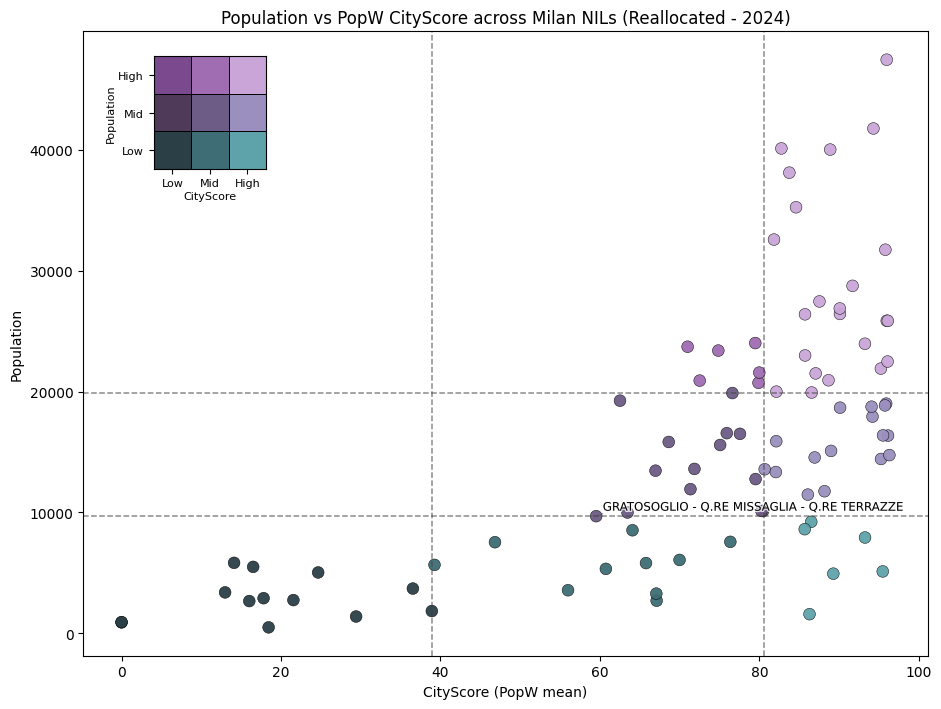

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patheffects as pe

# =========================
# CONFIG
# =========================
cube_mode   = "manual"
cube_size   = ("18%", "18%")
cube_loc    = "upper left"
cube_anchor = (0.20, 0.20)
cube_bounds = [0.06, 0.78, 0.18, 0.18]

PALETTE_NAME = "teal_purple"

DOT_SIZE   = 72
EDGE_LW    = 0.35
GRID_LW    = 1.1
GRID_ALPHA = 0.6

# Label styling
LABEL_FONT_SIZE = 8.5
LABEL_X_OFFSET = 0.02
LABEL_Y_OFFSET = 0.02
LABEL_COLOR = "black"
LINE_COLOR = "0.3"
LINE_WIDTH = 0.6
LINE_ALPHA = 0.8

# --- New: label filtering by NIL name
LABEL_FILTER = "GRATOSOGLIO"   # e.g. "conch" → selects all NIL names starting with or containing it (case-insensitive)

# =========================
# INPUTS
# =========================


df_ref       = pw_mean_24_real
df_target    = reloc_2024
xcol = 'cityscore_pw_mean'
ycol = 'pop_total'
name_col = 'NIL'

# =========================
# Palette & cube helper
# =========================
def bivariate_palette(name="teal_purple"):
    palettes = {
        "teal_purple": [
            "#2b3f46", "#3e6d75", "#5fa3aa",
            "#503a5a", "#6d5c85", "#9a8fbe",
            "#7b4a8e", "#a06db2", "#caa6d8",
        ],
        "blue_red": [
            "#2b3a67", "#3d59a6", "#5d82cf",
            "#6b3a54", "#8e5c74", "#b8829b",
            "#9a3a3a", "#c25b4f", "#e38a73",
        ],
        "green_orange": [
            "#2c3f2a", "#4f7449", "#78a770",
            "#6a4b27", "#8f7147", "#b99d73",
            "#a55c24", "#cc8345", "#efb36e",
        ],
    }
    return palettes[name]

PALETTE_3x3 = bivariate_palette(PALETTE_NAME)

def add_bivariate_cube_inset(ax, palette9, manual_bounds=None,
                             width="26%", height="26%", loc="upper right",
                             bbox_to_anchor=None, bbox_transform=None,
                             label_x="CityScore", label_y="Population"):
    if manual_bounds is not None:
        inax = ax.inset_axes(manual_bounds)
    else:
        if (isinstance(width, str) and "%" in width) or (isinstance(height, str) and "%" in height):
            if isinstance(bbox_to_anchor, (tuple, list)) and len(bbox_to_anchor) == 2:
                bbox_to_anchor = (*bbox_to_anchor, 1, 1)
                if bbox_transform is None:
                    bbox_transform = ax.transAxes
        from mpl_toolkits.axes_grid1.inset_locator import inset_axes
        inax = inset_axes(ax, width=width, height=height, loc=loc,
                          bbox_to_anchor=bbox_to_anchor, bbox_transform=bbox_transform,
                          borderpad=0.8)
    inax.set_aspect("equal")
    for pbin in range(3):
        for sbin in range(3):
            idx = pbin * 3 + sbin
            r = Rectangle((sbin, pbin), 1, 1, facecolor=palette9[idx],
                          edgecolor="k", linewidth=0.6)
            inax.add_patch(r)
    inax.set_xlim(0, 3); inax.set_ylim(0, 3)
    inax.set_xticks([0.5, 1.5, 2.5]); inax.set_yticks([0.5, 1.5, 2.5])
    inax.set_xticklabels(["Low", "Mid", "High"], fontsize=8)
    inax.set_yticklabels(["Low", "Mid", "High"], fontsize=8)
    for v in [1, 2]:
        inax.axvline(v, color='k', lw=0.6)
        inax.axhline(v, color='k', lw=0.6)
    inax.set_xlabel(label_x, fontsize=8, labelpad=2)
    inax.set_ylabel(label_y, fontsize=8, labelpad=2)
    for s in inax.spines.values(): s.set_linewidth(0.8)
    return inax

# =========================
# Compute tertiles & assign bins
# =========================
cols = [xcol, ycol]
tertiles_ref = compute_tertiles_from_df(df_ref, cols)
df_binned = apply_tertiles(df_target, tertiles_ref, "_bin")

s_lo, s_hi = tertiles_ref[xcol]
p_lo, p_hi = tertiles_ref[ycol]

df = df_binned.copy()
df["_sbin"] = df_binned[f"{xcol}_bin"]
df["_pbin"] = df_binned[f"{ycol}_bin"]
df["_bivar"] = df["_pbin"] * 3 + df["_sbin"]
color_map = dict(enumerate(PALETTE_3x3))
df["_color"] = df["_bivar"].map(color_map)

# =========================
# Plot
# =========================
fig, ax = plt.subplots(figsize=(9.6, 7.2))
plot_df = df.dropna(subset=[xcol, ycol, "_color"])

ax.scatter(plot_df[xcol], plot_df[ycol],
           c=plot_df["_color"], s=DOT_SIZE,
           edgecolor='k', linewidth=EDGE_LW, alpha=0.95, zorder=2)

ax.set_xlabel("CityScore (PopW mean)")
ax.set_ylabel("Population")
ax.set_title("Population vs PopW CityScore across Milan NILs (Reallocated - 2024)")

# tertile grid
ax.axvline(s_lo, color='0.25', lw=GRID_LW, ls='--', alpha=GRID_ALPHA)
ax.axvline(s_hi, color='0.25', lw=GRID_LW, ls='--', alpha=GRID_ALPHA)
ax.axhline(p_lo, color='0.25', lw=GRID_LW, ls='--', alpha=GRID_ALPHA)
ax.axhline(p_hi, color='0.25', lw=GRID_LW, ls='--', alpha=GRID_ALPHA)

# cube
add_bivariate_cube_inset(ax, PALETTE_3x3, manual_bounds=cube_bounds)

# =========================
# Labels (filtered by prefix + High CityScore bins)
# =========================
label_mask = (plot_df["_sbin"].isin([0,1,2]))  # High CityScore bin

if LABEL_FILTER:
    # Keep NILs whose name starts with / contains the prefix (case-insensitive)
    mask_prefix = plot_df[name_col].str.lower().str.startswith(LABEL_FILTER.lower()) | \
                  plot_df[name_col].str.lower().str.contains(LABEL_FILTER.lower())
    label_mask &= mask_prefix

labels_df = plot_df[label_mask]

# Draw leader lines + labels
for _, r in labels_df.iterrows():
    x, y = r[xcol], r[ycol]
    label_x = x + LABEL_X_OFFSET * (s_hi - s_lo)
    label_y = y + LABEL_Y_OFFSET * (p_hi - p_lo)

    ax.plot([x, label_x], [y, label_y],
            color=LINE_COLOR, lw=LINE_WIDTH, alpha=LINE_ALPHA, zorder=3)

    ax.text(label_x, label_y, r[name_col],
            fontsize=LABEL_FONT_SIZE, color=LABEL_COLOR,
            ha="left", va="bottom", zorder=4,
            path_effects=[pe.withStroke(linewidth=2, foreground="white", alpha=0.8)]
           )

plt.tight_layout()
plt.show()
